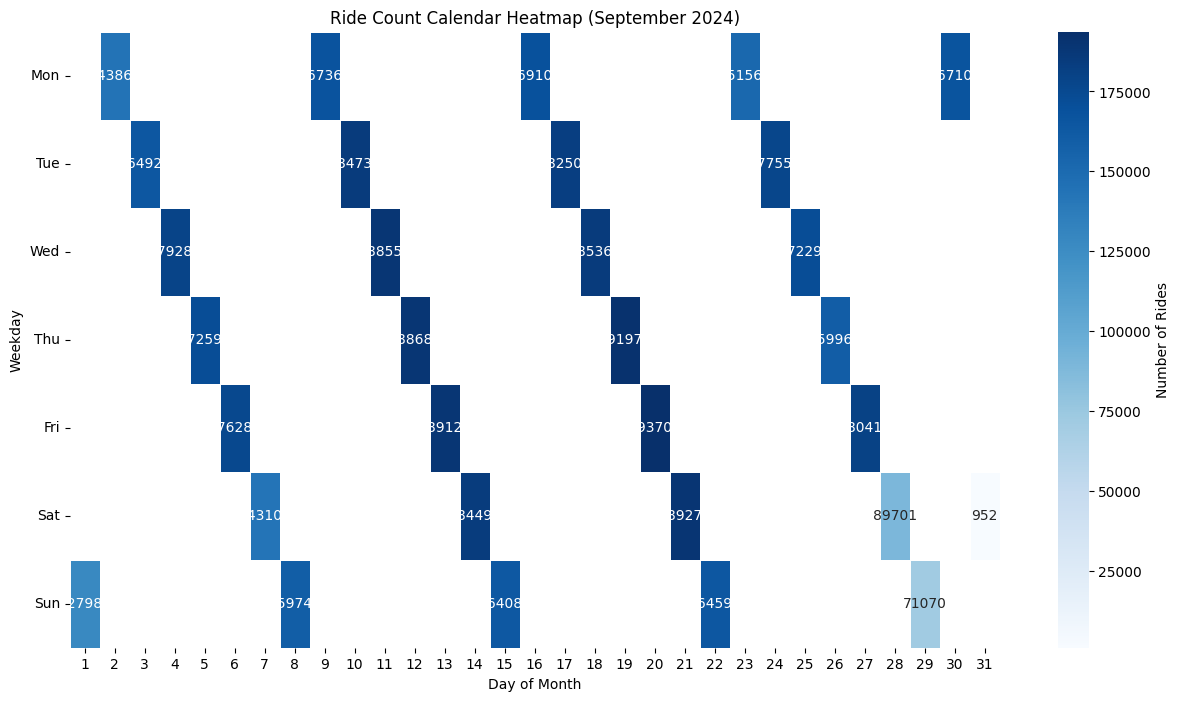

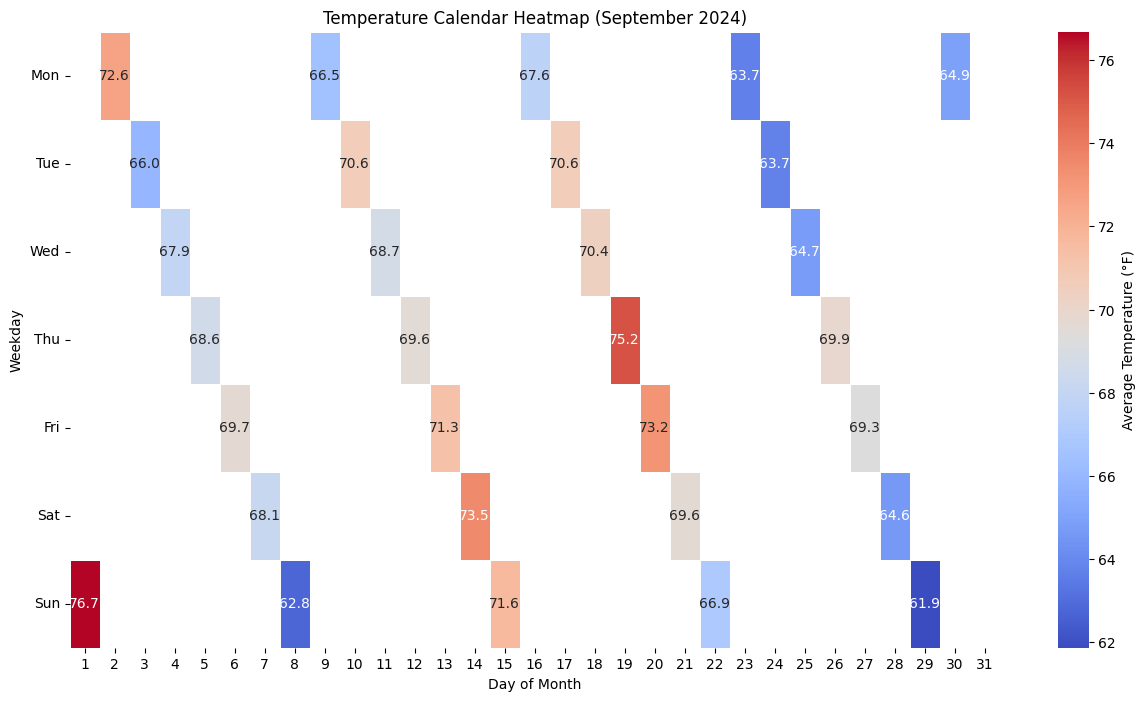

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the September 2024 bike data files
bike_data_sep_1 = pd.read_csv('202409-citibike-tripdata_1.csv', low_memory=False)
bike_data_sep_2 = pd.read_csv('202409-citibike-tripdata_2.csv', low_memory=False)
bike_data_sep_3 = pd.read_csv('202409-citibike-tripdata_3.csv', low_memory=False)
bike_data_sep_4 = pd.read_csv('202409-citibike-tripdata_4.csv', low_memory=False)
bike_data_sep_5 = pd.read_csv('202409-citibike-tripdata_5.csv', low_memory=False)

# Concatenate all the datasets together to create one large dataset
bike_data_sep = pd.concat([bike_data_sep_1, bike_data_sep_2, bike_data_sep_3, bike_data_sep_4, bike_data_sep_5], ignore_index=True)

# Load the September 2024 weather data
weather_data_sep = pd.read_csv('new york city 2024-09-01 to 2024-09-30 (2).csv', low_memory=False)

# Convert the 'started_at' and 'ended_at' columns to datetime objects in the bike data
bike_data_sep['started_at'] = pd.to_datetime(bike_data_sep['started_at'])
bike_data_sep['ended_at'] = pd.to_datetime(bike_data_sep['ended_at'])

# Drop rows with missing critical columns
bike_data_sep.dropna(subset=['start_station_name', 'end_station_name'], inplace=True)

# Clean column names
bike_data_sep.columns = bike_data_sep.columns.str.strip()

# Convert coordinates to numeric format
bike_data_sep[['start_lat', 'start_lng', 'end_lat', 'end_lng']] = bike_data_sep[['start_lat', 'start_lng', 'end_lat', 'end_lng']].apply(pd.to_numeric, errors='coerce')

# Remove duplicate rows based on 'ride_id'
bike_data_sep.drop_duplicates(subset='ride_id', inplace=True)

# Calculate the trip duration in seconds
bike_data_sep['duration'] = (bike_data_sep['ended_at'] - bike_data_sep['started_at']).dt.total_seconds()

# Filter out trips with negative duration
bike_data_sep = bike_data_sep[bike_data_sep['duration'] >= 0]

# Extract the hour from the 'started_at' column
bike_data_sep['hour'] = bike_data_sep['started_at'].dt.hour

# Convert the 'datetime' column in the weather data to datetime type
weather_data_sep['datetime'] = pd.to_datetime(weather_data_sep['datetime'])

# Extract the hour from the 'datetime' column
weather_data_sep['hour'] = weather_data_sep['datetime'].dt.hour

# Drop unnecessary columns from the weather data
columns_to_delete = ['preciptype', 'snow', 'sealevelpressure', 'solarradiation', 'solarenergy', 'severerisk']
weather_data_sep.drop(columns=columns_to_delete, inplace=True)

# Add a 'week' column to both datasets
bike_data_sep['week'] = bike_data_sep['started_at'].dt.isocalendar().week
weather_data_sep['week'] = weather_data_sep['datetime'].dt.isocalendar().week

# Merge the data based on 'week' and 'hour'
merged_data_sep = pd.merge(bike_data_sep, weather_data_sep, on=['hour', 'week'], how='left')

# Add 'week_of_month' column to both datasets
def get_week_of_month(date):
    return (date.day - 1) // 7 + 1

bike_data_sep['week_of_month'] = bike_data_sep['started_at'].apply(get_week_of_month)
weather_data_sep['week_of_month'] = weather_data_sep['datetime'].apply(get_week_of_month)

# Extract the date from the datetime columns
bike_data_sep['date'] = bike_data_sep['started_at'].dt.date
weather_data_sep['date'] = weather_data_sep['datetime'].dt.date

# Aggregate the weather data to get daily averages
daily_weather_avg = weather_data_sep.groupby('date').agg(
    avg_temp=('temp', 'mean'),
    avg_humidity=('humidity', 'mean'),
    avg_wind_speed=('windspeed', 'mean')
).reset_index()

# Merge the bike data with daily weather averages
merged_data_sep = pd.merge(bike_data_sep, daily_weather_avg, on='date', how='left')

# Group by the start station name and count the number of rides
station_counts = merged_data_sep['start_station_name'].value_counts().reset_index()
station_counts.columns = ['start_station_name', 'ride_count']

# Sort in descending order and select the top 10 stations
top_10_stations = station_counts.head(10)

# Filter the merged data to include only the top 10 stations
top_10_station_names = top_10_stations['start_station_name'].tolist()
top_10_station_data = merged_data_sep[merged_data_sep['start_station_name'].isin(top_10_station_names)]

# Extract day and weekday
merged_data_sep['day'] = merged_data_sep['started_at'].dt.day
merged_data_sep['weekday'] = merged_data_sep['started_at'].dt.weekday

# Aggregate data: Total rides and average temperature per day
daily_data = merged_data_sep.groupby(['day', 'weekday']).agg(
    ride_count=('ride_id', 'count'),
    avg_temp=('avg_temp', 'mean')
).reset_index()

# Pivot data for calendar view
ride_count_calendar = daily_data.pivot(index='weekday', columns='day', values='ride_count')
temperature_calendar = daily_data.pivot(index='weekday', columns='day', values='avg_temp')

# Weekday labels
weekday_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# Plot Ride Count Calendar Heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(
    ride_count_calendar,
    annot=True, fmt='.0f', cmap='Blues', linewidths=0.5,
    cbar_kws={'label': 'Number of Rides'}
)
plt.title('Ride Count Calendar Heatmap (September 2024)')
plt.xlabel('Day of Month')
plt.ylabel('Weekday')
plt.yticks(ticks=np.arange(7) + 0.5, labels=weekday_labels, rotation=0)
plt.show()

# Plot Temperature Calendar Heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(
    temperature_calendar,
    annot=True, fmt='.1f', cmap='coolwarm', linewidths=0.5,
    cbar_kws={'label': 'Average Temperature (°F)'}
)
plt.title('Temperature Calendar Heatmap (September 2024)')
plt.xlabel('Day of Month')
plt.ylabel('Weekday')
plt.yticks(ticks=np.arange(7) + 0.5, labels=weekday_labels, rotation=0)
plt.show()


In [3]:
merged_data_sep.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4981971 entries, 0 to 4981970
Data columns (total 23 columns):
 #   Column              Dtype         
---  ------              -----         
 0   ride_id             object        
 1   rideable_type       object        
 2   started_at          datetime64[ns]
 3   ended_at            datetime64[ns]
 4   start_station_name  object        
 5   start_station_id    object        
 6   end_station_name    object        
 7   end_station_id      object        
 8   start_lat           float64       
 9   start_lng           float64       
 10  end_lat             float64       
 11  end_lng             float64       
 12  member_casual       object        
 13  duration            float64       
 14  hour                int32         
 15  week                UInt32        
 16  week_of_month       int64         
 17  date                object        
 18  avg_temp            float64       
 19  avg_humidity        float64       
 20  av

In [ ]:
# Check for numerical columns in the dataset to set up a correlation 
numerical_columns = merged_data_sep.select_dtypes(include=['float64', 'int64', 'int32', 'UInt32']).columns

# Calculate the correlation matrix for the numerical columns
correlation_matrix = merged_data_sep[numerical_columns].corr()

# foccused it based on the duration column 
duration_correlation = correlation_matrix['duration'].sort_values(ascending=False)

# look at the correlations with 'duration'
print(duration_correlation)

Correlations with 'duration':
duration          1.000000
weekday           0.033943
avg_temp          0.025395
hour              0.023603
start_lat         0.016110
avg_wind_speed    0.004863
end_lat           0.004447
end_lng           0.000353
start_lng        -0.004657
avg_humidity     -0.013837
week_of_month    -0.027408
day              -0.028870
week             -0.036106
Name: duration, dtype: float64


In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#first we are starting with creating a correlation matrix based on our target variable duration. 
# check for numerical columns in the dataset to set up a correlation 
numerical_columns = merged_data_sep.select_dtypes(include=['float64', 'int64', 'int32', 'UInt32']).columns

# calculate the correlation matrix for the numerical columns
correlation_matrix = merged_data_sep[numerical_columns].corr()

# foccused it based on the duration column 
duration_correlation = correlation_matrix['duration'].sort_values(ascending=False)

# look at the correlations with 'duration'
print(duration_correlation)


# select features and target variable
#features are based on the correlation we saw earlier.
features = ['avg_temp','weekday','hour','start_lat','avg_wind_speed','end_lat','end_lng']  
target = 'duration'  

#drop rows with missing values in selected columns as some of these columns aren't cleaned before
merged_data_sep = merged_data_sep.dropna(subset=features + [target])

X = merged_data_sep[features]  
y = merged_data_sep[target]   

# split the data in a test and trainnig set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train the linear model regression
model = LinearRegression()
model.fit(X_train, y_train)

# make the predictions
y_pred = model.predict(X_test)

# look at the scores of the model 
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# print results
print(f"MAE = {mae}")
print(f"MSE= {mse}")
print(f"R² = {r2}")

duration          1.000000
weekday           0.033943
avg_temp          0.025395
hour              0.023603
start_lat         0.016110
avg_wind_speed    0.004863
end_lat           0.004447
end_lng           0.000353
start_lng        -0.004657
avg_humidity     -0.013837
week_of_month    -0.027408
day              -0.028870
week             -0.036106
Name: duration, dtype: float64
MAE = 496.9099429181498
MSE= 1211172.8919731895
R² = 0.002670456128054055
